# Basic Optimization
In this notebook I'll optimize a trough model to fit the data. This is a necessary first-step to fitting trough models and finding model parameters, as it cuts down on the burn-in required when running the MCMC.

This particular will optimize the most basic 0-0 model, in which both the accumulation and lag models are as simple as possible. The accumulation is linear in the insolation $A(t) = aI(t)$, with the parameter $a$ having units of m$^3$/W, and the lag model being $l(t) = l_0$, or a constant lag with the paramter $l_0$ having units of mm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import mars_troughs as mt
import emcee, corner
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True) #uncomment when we are ready to make final figures

In [3]:
#Create a trough object
test_acc_params = [1e-6]
acc_model_number = 0
test_lag_params = [1]
lag_model_number = 0
errorbar = 100.
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

(-505.53, 30)

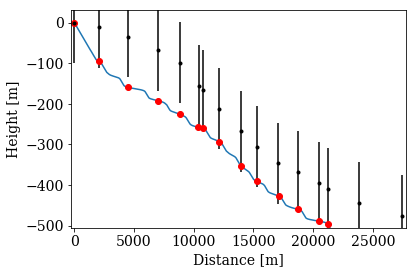

In [4]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
xlim = [np.min(tr.xdata)-300, np.max(tr.xdata)+300] #meters
ylim = [np.min(tr.ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)

In [5]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0:
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)

In [6]:
guess = [errorbar**2, test_acc_params[0], test_lag_params[0]]
result = op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
print(result)

 final_simplex: (array([[1.46581393e+03, 5.59247870e-07, 1.16893072e+00],
       [1.46583230e+03, 5.59247873e-07, 1.16893086e+00],
       [1.46588318e+03, 5.59247879e-07, 1.16893113e+00],
       [1.46582641e+03, 5.59247876e-07, 1.16893099e+00]]), array([66.32231537, 66.32231538, 66.32231539, 66.3223154 ]))
           fun: 66.322315370885
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 601
           nit: 324
        status: 1
       success: False
             x: array([1.46581393e+03, 5.59247870e-07, 1.16893072e+00])


In [7]:
#Set the model to the best model
best = result['x']
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2]])
tr.set_model(acc_params, lag_params, np.sqrt(variance))

(-505.53, 30)

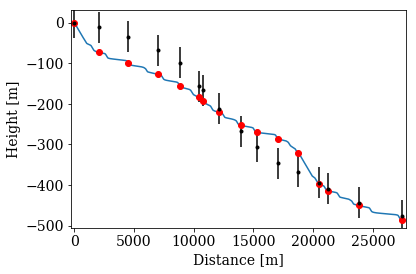

In [8]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)

## Using MCMC

Now we can explore the likelihood using MCMC. This allows us to view the _posterior distributions_ of the parameters. In this way, we can see which are degenerate with each other, and why the model may not be working.

In [9]:
ndim = len(result.x)
nwalkers = ndim*4
nburn = 200
nsteps = 2000
p0 = [result.x + 1e-3*result.x*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = sampler.run_mcmc(p0, nburn)

In [11]:
p0 = sampler.chain[:,-1]
sampler.reset()
_ = sampler.run_mcmc(p0, nsteps)

In [12]:
chain = sampler.flatchain

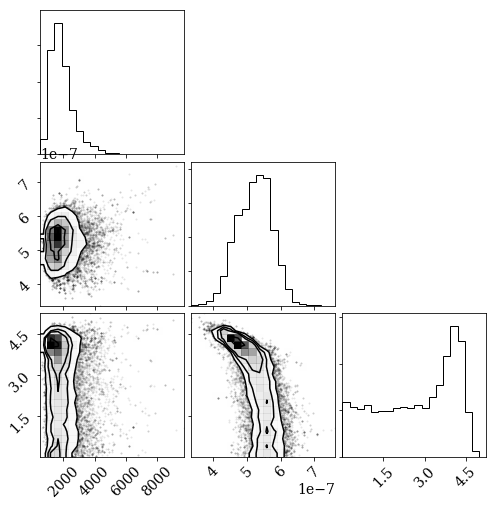

In [13]:
fig = corner.corner(chain)

[1.14142318e+03 4.67313395e-07 4.23871672e+00]


(-505.53, 30)

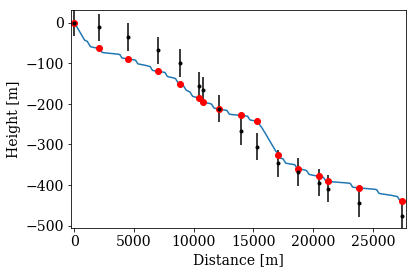

In [15]:
#Set the model to the best model
best = chain[np.argmax(sampler.flatlnprobability)]
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2]])
print(best)
tr.set_model(acc_params, lag_params, np.sqrt(variance))
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')
plt.xlabel(r"Distance [m]")
plt.ylabel(r"Height [m]")
plt.xlim(xlim)
plt.ylim(ylim)